# Esperimenti manuali
Di seguito, un esempio di validazione con 10-fold CV per il modello DGV_PT2 (previsione del tempo di esecuzione per la seconda ora di previsione usando il dataset a griglia variabile). Il modello è composto da due hidden layer rispettivamente di dimensione 14 e 7 (ognuno dei due layer usa ReLU come funzione di attivazione).
L'andamento di train e validation loss (media dei 10 run) in funzione dell'epoch è molto simile.

`cosmo_dlp` è un modulo, presente nel repository, che contiene tutto il codice che ho usato per il progetto. Il modello è implementato usando PyTorch.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.kfold import run_kfold

config = {
    "batch": "full",
    "kfold": 10,
    "model": {
        "layers": [{
            "size": 14,
            "dropout": 0.0,
        }, {
            "size": 7,
            "dropout": 0.0,
        }],
    },
    "loss": "mse",
    "optimizer": {
        "name": "adam",
        "lr": 0.01,
        "weight_decay": 0.0
    },
    "epochs": 3000,
}
df = pd.read_csv("data/input/DGV_PT2_train.csv")

res = run_kfold(config, df, pool_size=4)

Qui sotto, l'andamento di train loss e validation loss in funzione dell'epoch (si precisa che il modello prevede il logaritmo del tempo di esecuzione, quindi anche la loss function è in log(s)).

Si può notare come l'andamento di train e validation loss è praticamente uguale. Si può quindi assumere che converge?

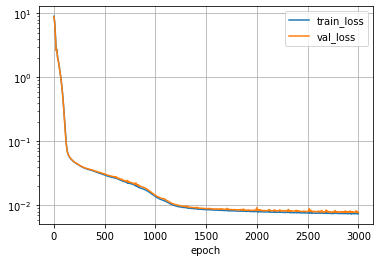

In [2]:
res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(logy=True, grid=True)
plt.show()

Zoom sulle epoch 200-400:

<AxesSubplot:xlabel='epoch'>

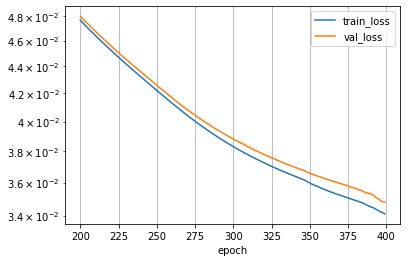

In [3]:
res.groupby("epoch")[["train_loss", "val_loss"]].mean().iloc[200:400].plot(logy=True, grid=True)

Zoom sulle ultime 100 epoch, in cui possiamo noate meglio come l'andamento delle due funzioni è quasi uguale (al netto di un offset)

<AxesSubplot:xlabel='epoch'>

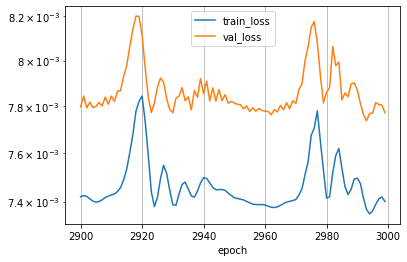

In [4]:
res.groupby("epoch")[["train_loss", "val_loss"]].mean().iloc[-100:].plot(logy=True, grid=True)

Lo stesso risultato si ottiene reimplementando il modello con Keras (anche normalizzazione dell'input e uso del logaritmo dell'output è fatto nello stesso modo dell'implementazione precedente, basata su PyTorch).

In [5]:
import numpy as np
import pandas as pd                                                             
from sklearn.preprocessing import MinMaxScaler   
from sklearn.model_selection import KFold
from keras import Sequential                                                    
from keras import Dense                                        
from keras.optimizers import Adam                                               
import matplotlib.pyplot as plt                                                 
import seaborn as sns

df = pd.read_csv('data/input/DGV_PT2_train.csv')

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
for n, (i, j) in enumerate(kfold.split(df)):
    tdf = df.iloc[i]
    vdf = df.iloc[j]
                                                                            
    tdf_i = tdf.iloc[:,:-1]
    tdf_o = tdf.iloc[:,-1:]
    vdf_i = vdf.iloc[:,:-1]
    vdf_o = vdf.iloc[:,-1:]

    scaler = MinMaxScaler().fit(tdf_i)
    train_x = scaler.transform(tdf_i)
    train_y = np.log(tdf_o)
    val_x = scaler.transform(vdf_i)
    val_y = np.log(vdf_o)

    model = Sequential()
    model.add(Dense(14, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.01))

    res = model.fit(train_x, train_y, epochs=3000, batch_size=train_x.shape[0], validation_data=(val_x, val_y), verbose=0)
    res = pd.DataFrame(res.history)
    res["epoch"] = res.index
    res["fold"] = n
    results.append(res)

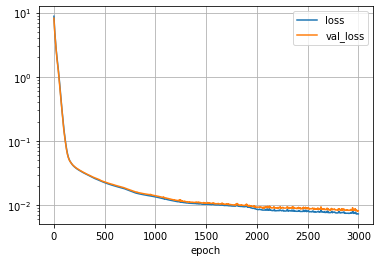

In [7]:
mean_loss = pd.concat([
    pd.DataFrame(res)
    for res in results
]).groupby("epoch")[["loss", "val_loss"]].mean()
mean_loss.plot(logy=True, grid=True)
plt.show()

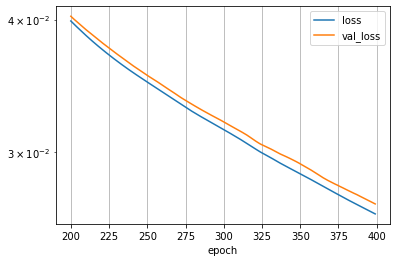

In [8]:
mean_loss[200:400].plot(logy=True, grid=True)
plt.show()

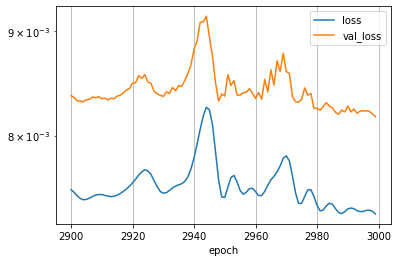

In [9]:
mean_loss[-100:].plot(logy=True, grid=True)
plt.show()

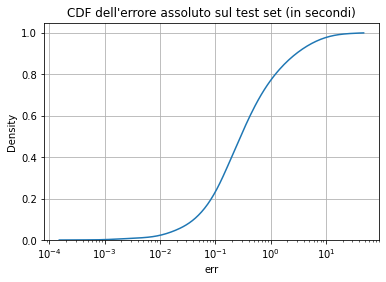

In [13]:
model = Sequential()
model.add(Dense(14, input_dim=train_x.shape[1], activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1))
model.compile(loss="mse", optimizer=Adam(learning_rate=0.01))

train_df = pd.read_csv('data/input/DGV_PT2_train.csv')
train_df_i = train_df.iloc[:,:-1]
train_df_o = train_df.iloc[:,-1:]
scaler = MinMaxScaler().fit(train_df_i)
train_x = scaler.transform(train_df_i)
train_y = np.log(train_df_o)
model.fit(train_x, train_y, epochs=3000, batch_size=train_x.shape[0], verbose=False)

test_df = pd.read_csv('data/input/DGV_PT2_test.csv')
test_x = scaler.transform(test_df.iloc[:,:-1])
test_y = np.log(test_df.iloc[:,-1:])
pred = model.predict(test_x, batch_size=test_x.shape[0], verbose=False)
test_df["pred"] = np.exp(pred)
test_df["err"] = (test_df.time2 - test_df.pred).abs()
sns.kdeplot(data=test_df, x="err", cumulative=True, log_scale=True, cut=0)
plt.grid()
plt.title("CDF dell'errore assoluto sul test set (in secondi)")
plt.show()